In [21]:
#@title Defining classes and functions useful for running the SDE estimations
# Defining some objects for running Gibbs sampling on different data, and for plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import geninvgauss, gamma, invgamma 
from datetime import datetime
from abc import abstractmethod

#function to define gig random variable, even for the edge cases:
def gig_rvs(a, b, p, size):
  '''
  Generate Generalized Inverse Gaussian random variables
  
  pdf: f(x, a, b, p) = ( (a/b)^{p/2} / (2 K_p(\sqrt{ab})) ) * x^{p-1} \exp(-ax + b/x)
        where a > 0, b > 0, p is a real number
  
  when a --> 0, GIG --> InvGamma; 
  when b --> 0, GIG --> Gamma;
  
  Special cases:
      Gamma(shape=alpha, rate=beta) = GIG(2*beta, 0, alpha)
      InvGamma(alpha, beta) = GIG(0, 2*beta, -alpha)
      InvGaussian(mu, lambda) = GIG(lambda/mu^2, lambda, −1/2)
      Park and Casella’s Lasso(alpha^2) = GIG(alpha^2, 0, 1)
  '''
  if a == 0 and b == 0:
      raise ValueError('GIG can not have input with both a and b being 0')
      
  if b == 0: # Gamma
      shape_gamma = p
      rate_gamma = a / 2
      rvs = gamma.rvs(a=shape_gamma, scale=1/rate_gamma, size=size)
      
  if a == 0: # InvGamma
      shape_invgamma = -p
      scale_invgamma = b / 2
      rvs = invgamma.rvs(a=shape_invgamma, scale=scale_invgamma, size=size)
      
  if a != 0 and b != 0:
      p_ss = p
      b_ss = np.sqrt(a*b)
      scale_ss = np.sqrt(a/b)
      rvs = geninvgauss.rvs(p=p_ss, b=b_ss, loc=0, scale=scale_ss, size=size)
  
  return rvs


#a class for running, printing, and calculating error for different priors for the SDE estimation
class Prior:
  def __init__(self, init_data, b_func, diffusion, kernel_name = 'gauss', m = 15000, n = 20):
      self._init_data = init_data
      self._kernel = self._set_kernel(kernel_name)
      self._b_func = b_func
      self.gibbs_iters = 150
      self.diffusion = diffusion 
      self.lambda_mat_record = []
      self.beta_record = [] 
      self.diffusion_est_record = []
      #this is based on how the input data was generated:
      #I dont have it as an input because all of the data we've generated so far has used t_delta=0.05
      self.t_delta = 0.05 
      self._m = m
      self._n = n
      self._b_mdata = None
      self._bhat_mdata = None
      self._b_cdf = None
      self._bhat_cdf = None
      self._mse = None
      self._kolmogorov = None

  #Using the specifications from initialization to set the kernel for the object
  def _set_kernel(self, kernel_name):
      if kernel_name.lower() == 'gauss':
          def kern(x,y): return np.exp(-((x-y)**2)/2)
          return kern
      if kernel_name.lower() == 'laplace':
          def kern(x,y): return np.exp(-abs(x-y)/np.sqrt(2))
          return kern
      if kernel_name.lower() == 'poly':
          order = 3 #TODO: add a way to specify this order when defining the class
          def kern(x,y): return np.exp(-abs(x-y)/np.sqrt(2)) (x*y + 1)**order
          return kern
      
  def _create_data(self, s):
      t = 0
      val = 0
      data = []
      t_delta = self.t_delta
      
      if s.lower() == 'b':
          def create_next(val):
              return val + self._b_func(val)*t_delta + self.diffusion*np.random.normal(0,np.sqrt(t_delta))
          
          for i in range(int(self._m)):
              data.append(val)
              val = create_next(val)
              t += t_delta
          return data
      
      elif s.lower() == 'bhat':
          assert self.beta_record != [], "Error: trying to generate data with bhat before bhat exists."
          def create_next(val):
              #this should change to use the last x% of data samples, not just beta_record[-20:]
              return val + self.get_b_hat(val, np.mean(self.beta_record[-20:], axis = 0))*t_delta + self.diffusion*np.random.normal(0,np.sqrt(t_delta))
          for i in range(int(self._m)):
              data.append(val)
              val = create_next(val)
              t += t_delta
          return data
  
  def get_b_hat(self, x, beta_vect):
      data = self._init_data
      return np.sum([beta_vect[i]*self._kernel(x, data[i]) for i in range(len(data)-1)])
  
  #define the matrix of k-values (kernel output for each possible pair of data points)
  #TODO: I want to try to vectorize this function, which will probably dramatically speed up the simulation speeds
  def get_k_matrix(self):
      data = self._init_data
      k_mat_len = len(data)-1
      k_mat = np.zeros((k_mat_len, k_mat_len))
      for i in range(k_mat_len):
          for j in range(k_mat_len):
              k_mat[i][j] = self._kernel(data[i], data[j])
      return np.array(k_mat)
  
  #create the c vector (pretty self-explanatory what this is)
  #TODO: would also be good to vectorize this
  def get_c_vect(self):
      data = self._init_data
      c_vect = []
      for i in range(1, len(data)):
          c_vect.append(data[i] - data[i-1])
      return np.array(c_vect)
  
  #returns the variance matrix
  #zeta and t_delta come from the formula that was used to create the data set
  #in the case of gibbs sampling, zeta changes for each iteration
  def get_variance_matrix(self, k_mat, zeta, lambda_mat):
      #perform calculations, as per the formulas that jinpu derived
      part_1 = (self.t_delta/zeta)*(k_mat.T @ k_mat)
      part_2 = np.linalg.inv(lambda_mat)
      return np.linalg.inv(part_1 + part_2)
  
  #outputs the vector of mean values for each beta_i
  def get_mu_vector(self, variance_matrix, zeta, c_vect, k_mat):
      kt_times_c = k_mat.T @ c_vect
      return np.matmul(variance_matrix/zeta, kt_times_c)

  @abstractmethod
  def run_gibbs(self, verbose = True):
      pass
  
  def set_metric_data_size(self, m):
      assert self._b_mdata != [] and self._bhat_mdata != [], f'Metric test data has already been generated using m = {self.__m}; manually reset __b_mdata and __bhat_mdata to change m'
      self._m = m
          
  def _create_mdata(self, s):
      #frankly, this could be turned into a single function,instead of calling the hidden funciton too
      if 'bhat' in s.strip():
          self._bhat_mdata = self._create_data(s)[int(self._m/10):]
      elif 'b' in s.strip():
          #the indexing at the end is to remove the first 10% of data
          self._b_mdata = self._create_data(s)[int(self._m/10):]
      else:
          raise Exception('invalid keyword for _create_mdata')
  
  #plots a histogram of the data that is available
  def data_hist(self,s, smoothing = True):
    if smoothing:
      if 'bhat' == s.lower():
          if self._bhat_mdata != None:
              sns.displot(self._bhat_mdata, kind = "kde", fill = True)
              plt.title("bhat generated data histogram")
              plt.show()  
          else: raise Exception("cannot make a histogram for data that doesn't exist yet (bhat)")
      elif "b" == s.lower():
          if self._b_mdata != None:
              sns.displot(self._b_mdata, kind = "kde", fill = True)
              plt.title("true b generated data histogram")
              plt.show()
          else:
              raise Exception("cannot make a histogram for data that doesn't exist yet (b)")
      elif s.lower() == 'original':
          sns.displot(self._init_data, kind = "kde", fill = True)
          plt.title("True b original learning data histogram")
          plt.show()
      else:
          raise Exception('invalid keyword for data_hist; use "bhat", "b", or "original".')
    else:
      if 'bhat' == s.lower():
          if self._bhat_mdata != None:
              sns.displot(self._bhat_mdata, bins = 100, stat ='density')
              plt.title("bhat generated data histogram")
              plt.show()  
          else: raise Exception("cannot make a histogram for data that doesn't exist yet (bhat)")
      elif "b" == s.lower():
          if self._b_mdata != None:
              sns.displot(self._b_mdata, bins = 100, stat ='density')
              plt.title("true b generated data histogram")
              plt.show()
          else:
              raise Exception("cannot make a histogram for data that doesn't exist yet (b)")
      elif s.lower() == 'original':
          sns.displot(self._init_data, bins = 100, stat ='density')
          plt.title("True b original learning data histogram")
          plt.show()
      else:
          raise Exception('invalid keyword for data_hist; use "bhat", "b", or "original".')
  def plot_b_vs_bhat(self):
      # plotting bhat using the averaged last n values recorded from gibbs
      # can be made more efficient
      n = self._n
      x_vals = self._init_data
      last_n_beta_avg = np.mean(np.array(self.beta_record[-n:]), axis = 0)
      avgd_beta_est = [self.get_b_hat(x, last_n_beta_avg) for x in x_vals]
      plt.scatter(x_vals, avgd_beta_est, c = 'red', label = f'Approximated b, averaged last {n} gibbs samples', s= 2)
      plt.scatter(x_vals, [self._b_func(x) for x in x_vals], c = 'blue', label = 'True b', s= 2)
      
  def plot_shrinkage(self):
      last_beta = self.beta_record[-1]
      plt.hist(last_beta, bins = 50)
  
  def find_mse(self):
      #when sampling the last few values of beta to get bhat, do we 
      # 1) average n beta vectors, then calc the bhat values using the average, or
      #2) calc bhat values for n different beta vectors, and average the bhat values?
      #hypothesis: betas are the thing being sampled, so we should average them first.
      if self._mse == None:
          n = self._n
          data = self._init_data
          self._mse = (1/len(data))*np.sum(np.array([self.get_b_hat(x, 
              np.mean(np.array(self.beta_record[-n:]), axis = 0)) - self._b_func(x) for x in data])**2)
      else: raise Exception('no point recalculating mse error; you can use "return_mse()" to output it.')
  
  def return_mse(self):
      return self._mse
  
  def _calc_cdf(self, s):
      if 'bhat' == s.lower():
          self._bhat_cdf = (1/len(self._bhat_mdata))*np.array([np.sum(np.where(np.array(self._bhat_mdata) <= x, 1, 0)) for x in self._init_data])
      elif 'b' == s.lower():
          self._b_cdf = (1/len(self._b_mdata))*np.array([np.sum(np.where(np.array(self._b_mdata) <= x, 1, 0)) for x in self._init_data])
      else: 
          raise Exception('must call _calc_cdf using string "bhat" or "b".')
      
  def find_kolmogorov(self):
      if self._kolmogorov == None:
          self._create_mdata('b')
          self._create_mdata('bhat')
          self._calc_cdf('bhat')
          self._calc_cdf('b')
          self._kolmogorov = np.max(np.absolute(self._b_cdf - self._bhat_cdf))
          
  def return_kolmogorov(self):
      return self._kolmogorov

#a child of the Prior class; Gig (generalized inverse gaussian)
class Gig(Prior):
  def __init__(self, init_data, b_func, diffusion, kernel_name = 'gauss', m = 100000, n = 20, gig_params = [2,2,1,0,1]):
    super().__init__(init_data, b_func, diffusion, kernel_name = 'gauss', m = 100000, n = 20)
    self._gig_params = gig_params #default is a=1 b=0 p=1 for lasso prior (see run_gibbs method)

  def run_gibbs(self, verbose = True):
    k_mat = self.get_k_matrix()
    c_vect = self.get_c_vect()
    data_len= len(self._init_data)
    #TODO add a way to specify these following starting priors; 
    #right now just set to diffusion = 0.5 and beta = np.zeros()
    zeta = 0.5**2 #a scalar (noise coeff)
    beta = np.zeros(data_len) #a vector (beta coeffs)
    lambda_mat = np.identity(data_len - 1)
    
    #NOTE: _gig_params in order [c,d,a,b,p] (the last three specify gig.rvs)
    c,d,a,b,p = self._gig_params
    c_prime = c + (data_len-1)/2
    t_delta = self.t_delta
    assert self.lambda_mat_record == [] and self.beta_record == [] and self.diffusion_est_record == [], 'you have already ran the gibbs process for this object; run obj.reset to forget these results'
    
    for i in range(self.gibbs_iters):
        #draw a diagonal matrix of lambda^2 values, using the inverse gamma distribution
        #this replaces the 1 values inside of lambda_mat
        np.fill_diagonal(lambda_mat, [gig_rvs(a, (beta[i]**2+b), p - 1/2, 1) for i in range(data_len - 1)])
        #Don't know if this shoul dbe there; it seems to really mess up results:
        # lambda_mat = lambda_mat**2 
        #use this matrix to compute the matrix and covariance for beta vector
        #sample from these values
        variance_matrix = self.get_variance_matrix(k_mat, zeta, lambda_mat)
        mu_vect = self.get_mu_vector(variance_matrix, zeta, c_vect, k_mat)
        beta = np.random.multivariate_normal(mu_vect,variance_matrix)
        
        #draw a new guess for zeta given the beta and lambda_mat values
        #it is an inverse gamme of c_prime and d_prime, defined below
        d_prime_1 = (1/(2*t_delta))*np.sum(c_vect**2)
        d_prime_2 = t_delta/2* (beta.T @ (k_mat.T @ (k_mat @ beta))) - c_vect.T @ (k_mat @ beta) + d
        d_prime = d_prime_1 + d_prime_2
        zeta = 1/np.random.gamma(shape = c_prime, scale = 1/d_prime)
        
        #keeping track of things here
        if verbose:
            if i%25 == 0:
              print(f'step {i} completed')
        self.lambda_mat_record.append(lambda_mat)
        self.beta_record.append(beta)
        self.diffusion_est_record.append(zeta)

  def plot_b_vs_bhat(self):
    super().plot_b_vs_bhat()
    plt.title(f'graph using GIG Prior (params a,b,p = {self._gig_params[2:]})')
    plt.legend()
    plt.show()

  def plot_shrinkage(self):
    super().plot_shrinkage()
    plt.title('GIG: final beta sample/shrinkage plot')
    plt.show()


#a very similar class, but now for inverse gamma gibbs smapling, rather than generalized inverse gauss (IG vs GIG)
class Ig(Prior):
  def __init__(self, init_data, b_func, diffusion, kernel_name = 'gauss', m = 100000, n = 20, ig_params = [2,2,1,2]):
    super().__init__(init_data, b_func, diffusion, kernel_name = 'gauss', m = 100000, n = 20)
    self._ig_params = ig_params #the default is to test the t-prior here
        
  def run_gibbs(self, verbose = True):
      k_mat = self.get_k_matrix()
      c_vect = self.get_c_vect()
      data_len= len(self._init_data)
      #TODO add a way to specify these following starting priors; 
      #right now just set to diffusion = 0.5 and beta = np.zeros()
      zeta = 0.5**2 #a scalar (noise coeff)
      beta = np.zeros(data_len) #a vector (beta coeffs)
      lambda_mat = np.identity(data_len - 1)
      
      c,d,a,b = self._ig_params
      c_prime = c + (data_len-1)/2
      t_delta = self.t_delta
      assert self.lambda_mat_record == [] and self.beta_record == [] and self.diffusion_est_record == [], 'you have already ran the gibbs process for this object; run obj.reset to forget these results'
      
      for i in range(self.gibbs_iters):
          #draw a diagonal matrix of lambda^2 values, using the inverse gamma distribution
          #this replaces the 1 values inside of lambda_mat
          np.fill_diagonal(lambda_mat, [1/np.random.gamma(a + 1/2, 1/(b + (1/2) * beta[i]**2)) for i in range(data_len - 1)])
          #Don't know if this shoul dbe there; it seems to really mess up results:
          # lambda_mat = lambda_mat**2 
          #use this matrix to compute the matrix and covariance for beta vector
          #sample from these values
          variance_matrix = self.get_variance_matrix(k_mat, zeta, lambda_mat)
          mu_vect = self.get_mu_vector(variance_matrix, zeta, c_vect, k_mat)
          beta = np.random.multivariate_normal(mu_vect,variance_matrix)
          
          #draw a new guess for zeta given the beta and lambda_mat values
          #it is an inverse gamme of c_prime and d_prime, defined below
          d_prime_1 = (1/(2*t_delta))*np.sum(c_vect**2)
          d_prime_2 = t_delta/2* (beta.T @ (k_mat.T @ (k_mat @ beta))) - c_vect.T @ (k_mat @ beta) + d
          d_prime = d_prime_1 + d_prime_2
          zeta = 1/np.random.gamma(shape = c_prime, scale = 1/d_prime)
          
          #keeping track of things here
          if verbose:
              if i%25 == 0:
                  print(f'step {i} completed')
          self.lambda_mat_record.append(lambda_mat)
          self.beta_record.append(beta)
          self.diffusion_est_record.append(zeta)
    
  def plot_b_vs_bhat(self):
      # plotting bhat using the averaged last n values recorded from gibbs
      super().plot_b_vs_bhat()
      plt.title(f'graph using Inverse Gamma prior (params [a, b] = {self._ig_params[-2:]}')
      plt.legend()
      plt.show()
      
  def plot_shrinkage(self):
      super().plot_shrinkage()
      plt.title('IG: final beta sample/shrinkage plot')
      plt.show()

#a very similar class, but now for inverse gamma gibbs smapling, rather than generalized inverse gauss (IG vs GIG)
class Shoe(Prior):
  def __init__(self, init_data, b_func, diffusion, kernel_name = 'gauss', m = 2000, n = 20):
      super().__init__(init_data, b_func, diffusion, kernel_name = 'gauss', m = 100000, n = 20)

  def run_gibbs(self, verbose = True):
      k_mat = self.get_k_matrix()
      c_vect = self.get_c_vect()
      data_len= len(self._init_data)
      #TODO add a way to specify these following starting priors; 
      #right now just set to diffusion = 0.5 and beta = np.zeros()
      zeta_sq = 1/np.random.gamma(1, 1/2) #The noise coefficient (squared), prior is from inverse gamma (a = 1, b = 2; these are not specific)
      #new variables for the gibbs process
      xi = np.random.gamma(1/2,1) 
      eps = np.array([np.random.gamma(1/2, 1) for i in range(data_len- 1)])
      tau_sq = 1/np.random.gamma(1/2, xi)
      lambda_mat = np.identity(data_len - 1)
      #classic beta vector and lambda matrix for gibbs:
      np.fill_diagonal(lambda_mat, [1/np.random.gamma(1/2, eps[i]) for i in range(data_len - 1)])
      beta = np.array([np.random.normal(0,lambda_mat[i,i]*tau_sq) for i in range(data_len - 1)]) #a vector (beta coeffs)  
      #idk if these next variables are right; I made them up to fit the code but they could be improper
      a, c, d = 0.5, 1, 1
      c_prime = c + (data_len-1)/2 
      t_delta = self.t_delta
      assert self.lambda_mat_record == [] and self.beta_record == [] and self.diffusion_est_record == [], 'you have already ran the gibbs process for this object; run obj.reset to forget these results'
      
      for i in range(self.gibbs_iters):
          #draw a diagonal matrix of lambda^2 values, using the inverse gamma distribution
          #this replaces the 1 values inside of lambda_mat
          np.fill_diagonal(lambda_mat, [1/np.random.gamma(1, 1/(1/eps[i] + (1/2)*tau_sq*beta[i]**2)) for i in range(data_len - 1)])
          #Don't know if this shoul dbe there; it seems to really mess up results:
          # lambda_mat = lambda_mat**2 
          #use this matrix to compute the matrix and covariance for beta vector
          #sample from these values
          variance_matrix = self.get_variance_matrix(k_mat, zeta_sq, lambda_mat)
          mu_vect = self.get_mu_vector(variance_matrix, zeta_sq, c_vect, k_mat)
          beta = np.random.multivariate_normal(mu_vect,variance_matrix)
          
          #draw a new guess for zeta_sq given the beta and lambda_mat values
          #it is an inverse gamme of c_prime and d_prime, defined below
          d_prime_1 = (1/(2*t_delta))*np.sum(c_vect**2)
          d_prime_2 = t_delta/2* (beta.T @ (k_mat.T @ (k_mat @ beta))) - c_vect.T @ (k_mat @ beta) + d
          d_prime = d_prime_1 + d_prime_2
          zeta_sq = 1/np.random.gamma(shape = c_prime, scale = 1/d_prime)
          
          #new variable changes
          tau_arg2 = max([0.0001,1/(1/2*np.sum(np.array([beta[i]/lambda_mat[i,i] for i in range(data_len - 1)]))+1/xi)])
          tau_sq = 1/np.random.gamma(data_len/2, tau_arg2)
          eps = np.array([1/np.random.gamma(1, 1/(1/lambda_mat[i,i] + 1)) for i in range(data_len - 1)])
          xi = 1/np.random.gamma(1, 1/(1/tau_sq + 1))

          #keeping track of things here
          if verbose:
              if i%25 == 0:
                  print(f'step {i} completed')
          self.lambda_mat_record.append(lambda_mat)
          self.beta_record.append(beta)
          self.diffusion_est_record.append(zeta_sq)
          
  def plot_b_vs_bhat(self):
      # plotting bhat using the averaged last n values recorded from gibbs
      super().plot_b_vs_bhat()
      plt.title(f'graph using Horseshoe Prior')
      plt.legend()
      plt.show()
      
  def plot_shrinkage(self):
      super().plot_shrinkage()
      plt.title('Horseshoe: final beta shrinkage plot')
      plt.show()

In [14]:
#@title More Helper Functions
def create_data(diffusion, b_func, t_delta, t_end, start_val):
    t = 0
    val = start_val
    data = []
    
    def create_next(val):
        return val + b_func(val)*t_delta + diffusion*np.random.normal(0,np.sqrt(t_delta))
    
    while t < t_end - t_delta:
        data.append(val)
        val = create_next(val)
        t += t_delta

    return data

def check_start_data(b_func, diffusion, t_end):
    init_data = create_data(diffusion, b_func, 0.05, t_end, 0)
    plt.hist(init_data, bins = 100, density = True)
    plt.show()
    s = input('Are you happy with the way this data looks? [y/n]\n')
    while s.lower() != 'y':
        init_data = create_data(diffusion, b_func, 0.05, t_end, 0)
        plt.hist(init_data, bins = 100, density = True)
        plt.show()
        s = input('Are you happy with the way this data looks? [y/n] \n')
    return init_data

def do_calcs_and_save_errors(sde_obj, name):
    if input(f'Do you want to run the gibbs process for {name}? [y/n] \n').lower() =='y':
        sde_obj.run_gibbs()
        sde_obj.plot_b_vs_bhat()
        sde_obj.find_mse()
        sde_obj.find_kolmogorov() #in this function, check if CDF exists and ask to create it if not
        mse = sde_obj.return_mse()
        kolmo = sde_obj.return_kolmogorov()
        sde_obj.data_hist("b")
        sde_obj.data_hist("bhat")
        sde_obj.plot_shrinkage()
        print(f'MSE for {name} = {mse}.\nKolmogorov Error for {name} = {kolmo}')
    
        now = datetime.now()
        dt_string = now.strftime("%d-%m-%Y_%H-%M")
        np.save(f'{name}_MSE_Kolmo_{dt_string}', np.array(mse, kolmo))
    else: 
        raise Exception('Gibbs process cancelled')

#for general use: code that does n runs of the gibbs process and returns the mse/kol values!
def avg_n(n, init_data, b, diffusion, Cls):
  trials = n
  mse = np.zeros(trials)
  kol = np.zeros(trials)
  for i in range(trials):
    print(f'run {i}')
    sde_obj = Cls(init_data, b, diffusion)
    sde_obj.run_gibbs(verbose = False)
    sde_obj.find_mse()
    sde_obj.find_kolmogorov()
    mse[i] = sde_obj.return_mse()
    kol[i] = sde_obj.return_kolmogorov()
  #plotting the shrinkage graph for the last of the ten runs
  sde_obj.plot_shrinkage()
  return mse, kol

def run_all_processes(params):
    results = {}
    grid = [(func_name, init_data, b, diffusion, Cls) for func_name, init_data, b, diffusion in params for Cls in [Gig, Ig, Shoe]]
    for func_name, init_data, b, diffusion, Cls in grid:
        print(f'with b = {func_name} and Cls = {Cls}...')
        #need to write mse and kolmo values to some dataframe (dict for now) to view it
        mse, kol = avg_n(5, init_data, b, diffusion, Cls)
        if Cls == Ig: id = func_name + '; Ig'
        elif Cls == Gig: id = func_name + '; Gig'
        elif Cls == Shoe: id = func_name + '; Shoe'
        results[id] = mse, kol
    return results

#quick wrapper for generating data and showing histogram
def gen_data_and_hist(b, diff):
    init_data = create_data(diff, b, 0.05, 50, 0)
    plt.hist(init_data, bins = 100, density = True)
    plt.show()
    return init_data
#function for making the list of params to run through the run_all_processes function
#basically, for each b, find a diffusion coefficient and data set that looks good and add them to the list
#input is a 2d array (nx2) where each entry is [b,diffusion] (there are n number of b functions we are looking at)
def make_params(b_diff_list):
    params = []
    for func_name, b, diff in b_diff_list:
        init_data = gen_data_and_hist(b, diff)
        while True:
            s = input('Enter "y" to use this data, "n" to make data again with this diffusion, \nor a number from 0.1 - 1.5 to make new data with diff = num: ')
            if s == 'y':
                break
            elif s == 'n':
                init_data = gen_data_and_hist(b, diff)
            elif float(s) <= 1.5 and float(s) >= 0.1:
                diff = float(s)
                init_data = gen_data_and_hist(b, diff)
        params.append([func_name, init_data, b, diff])
    return params

In [15]:
b_diff_list = [['b = -x', lambda x: -x, 1],
               ['b = 4*(x-x**3)', lambda x: 4*(x-x**3), 0.8],
               ['b = -(x**3)/(1+x**2)', lambda x: -(x**3)/(1+x**2), 0.2],
               ['b = -x*(1 + 0.5*np.sin(x))', lambda x: -x*(1 + 0.5*np.sin(x)), 0.2],
               ['b = 4*(1-x*(np.sin(x)**2 + 0.1))', lambda x: 4*(1-x*(np.sin(x)**2 + 0.1)), 0.5]]
# params = make_params(b_diff_list)

In [ ]:
results = run_all_processes(params)

In [ ]:
# mse = np.array([np.mean(v[0]) for v in results.values()])
# kolmo = np.array([np.mean(v[1]) for v in results.values()])

In [ ]:
np.save('my_file.npy', results) 

In [ ]:
#running for b(x) = 4(x-x^3)
# t_end = 50
  
# diffusion = 0.8
# def b(val): return 4*(val-val**3)
# init_data = check_start_data(b, diffusion, t_end)

# gig_sin = Gig(init_data, b, diffusion)
# do_calcs_and_save_errors(gig_sin, 'GIG_sin')
# ig_sin = Ig(init_data, b, diffusion)
# do_calcs_and_save_errors(ig_sin, 'T-prior_sin')

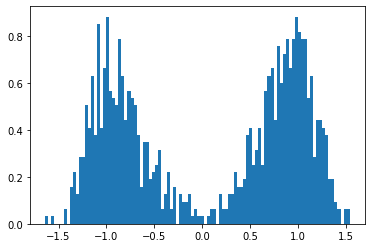

Are you happy with the way this data looks? [y/n]
y
Do you want to run the gibbs process for GIG_doubleWell? [y/n] 
y
step 0 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:269: RuntimeWarning: covariance is not positive-semidefinite.


step 25 completed
step 50 completed
step 75 completed
step 100 completed
step 125 completed


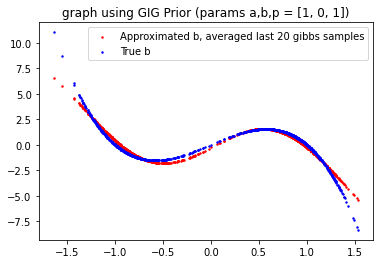

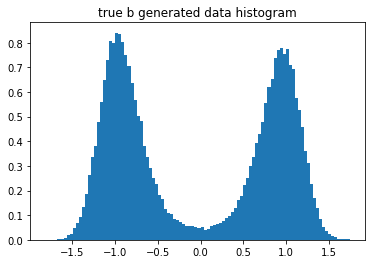

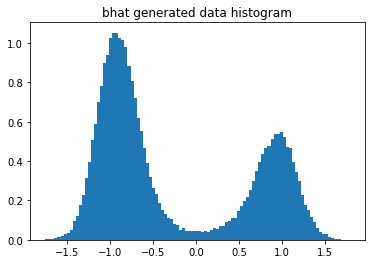

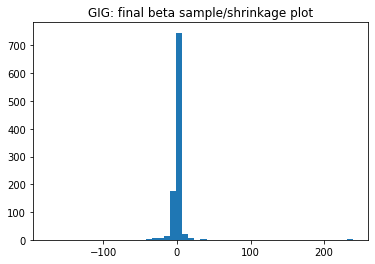

MSE for GIG_doubleWell = 0.14669902566323628.
Kolmogorov Error for GIG_doubleWell = 0.13793333333333324
Do you want to run the gibbs process for T-prior_doubleWell? [y/n] 
y
step 0 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:329: RuntimeWarning: covariance is not positive-semidefinite.


step 25 completed
step 50 completed
step 75 completed
step 100 completed
step 125 completed


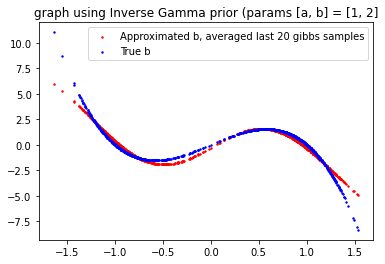

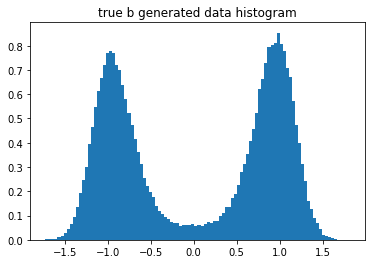

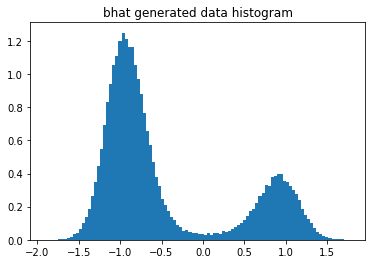

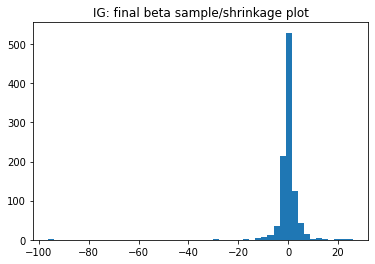

MSE for T-prior_doubleWell = 0.18883756836997131.
Kolmogorov Error for T-prior_doubleWell = 0.2718111111111111
Do you want to run the gibbs process for HorseShoe_doubleWell? [y/n] 
y


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:394: RuntimeWarning: covariance is not positive-semidefinite.


step 0 completed
step 25 completed
step 50 completed
step 75 completed
step 100 completed
step 125 completed


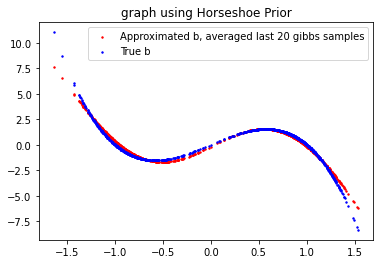

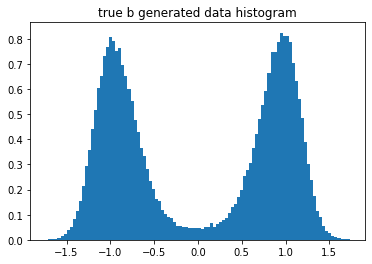

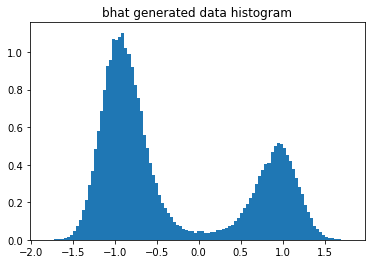

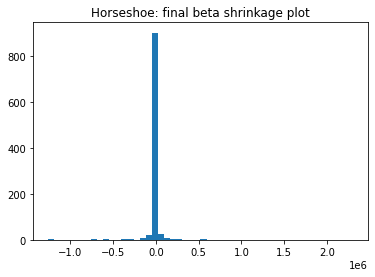

MSE for HorseShoe_doubleWell = 0.08010805989124714.
Kolmogorov Error for HorseShoe_doubleWell = 0.18657777777777784


In [18]:
#@title Double Well data setup
#Setting up the data for the double well (run the cells below once you generate data you are happy with)
t_end = 50
diffusion = 0.8
b = b_diff_list[1][1]
init_data = check_start_data(b, diffusion, t_end)
#@title Double Well Gibbs Process + Graphing
gig_dw = Gig(init_data, b, diffusion)
do_calcs_and_save_errors(gig_dw, 'GIG_doubleWell')
ig_dw = Ig(init_data, b, diffusion)
do_calcs_and_save_errors(ig_dw, 'T-prior_doubleWell')
shoe_dw = Shoe(init_data, b, diffusion)
do_calcs_and_save_errors(shoe_dw, 'HorseShoe_doubleWell')